# Обработка данных к ВПВ
В работе исследуются три зависимости:
1. Интенсивность поглощения от угла 
2. Величина g-фактора от угла
3. Ширина линии поглощения от угла

## Объявление необходимых библиотек

In [2]:
import pandas as pd 
from scipy.optimize import curve_fit 
import numpy as np
import matplotlib.pyplot as plt

## Пересчет показаний приборов в необходимые величины
Показания датчика Холла переводятся в ...
Ток на .. переводится в ...

## Визуализация для одного положения при разных частотах
Напишем функцию, подгоняющую данные по формуле и построим график

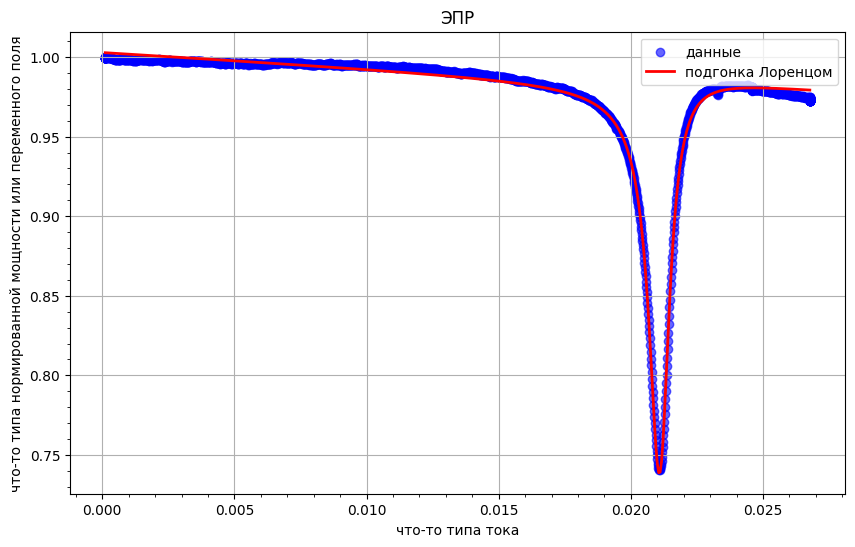

Fitted parameters:
u0 = 1.0038, x0 = 2.1113e-02, k = -0.9696, a = 0.2477, b = 83.5217, d = 4.6680e-04


In [3]:
# Функция Лоренца
def lorentzian(x, u0, x0, k, a, b, d): # u0 убрал из формулы, тк в итоге работаем с нормированными величинами, но оставим её здесь на всякий случай
    return u0*(1 + k * x) * (
        1 - a / (1 + ((x - x0) / d) ** 2) + b * (x - x0) / (1 + ((x - x0) / d) ** 2)
    )

# Считывание данных из файла
filename = '/home/golenn/EPR/data/01 11GHz 270degr.dat'
data = pd.read_csv(filename, skiprows=3, sep='\t')
data.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
x_data = data["X_channel"].values
y_data = data["Y_channel"].values

# Нормировка по Y
y_max = max(y_data)
for i in range(len(y_data)):
    y_data[i] = y_data[i] / y_max 

# Начальные приближения параметров
u0_guess = 1
x0_guess = x_data[np.argmax(y_data)]
initial_guess = [u0_guess, x0_guess, 0.1, 0.1, 0.1, 0.1]

# Подбор параметров
params, params_cov = curve_fit(lorentzian, x_data, y_data, p0=initial_guess)

# Генерация кривой для графика
x_fit = np.linspace(min(x_data), max(x_data), 500)
y_fit = lorentzian(x_fit, *params)

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, color='blue', label='данные', alpha=0.6)
#plt.scatter(x_data[np.argmax(x_data):], y_data[np.argmax(x_data):], color='green', label='данные', alpha=0.6)
plt.plot(x_fit, y_fit, color='red', label='подгонка Лоренцом', linewidth=2)
plt.title('ЭПР')
plt.ylabel('что-то типа нормированной мощности или переменного поля')
plt.xlabel('что-то типа тока')
plt.legend()
plt.grid()
plt.minorticks_on()

#plt.savefig(fname='EPR 9 GHz')
plt.show()
# Вывод параметров
print("Fitted parameters:")
print(f"u0 = {params[0]:.4f}, x0 = {params[1]:.4e}, k = {params[2]:.4f}, "
      f"a = {params[3]:.4f}, b = {params[4]:.4f}, d = {params[5]:.4e}")


отдельный просчет для 9 ГГц, тк разный дрейф при увелечении и уменьшении тока 

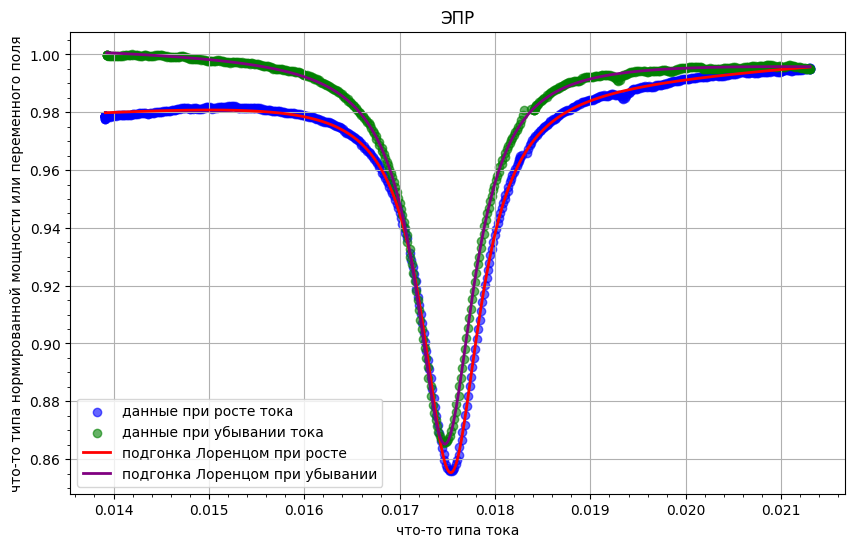

Интерполяционные коэффициенты для возрастания тока:
u0 = 0.9514, x0 = 1.7535e-02, k = 2.2508, a = 0.1352, b = -1.0217, d = -3.6888e-04
Интерполяционные коэффициенты для убывания тока:
u0 = 1.0126, x0 = 1.7477e-02, k = -0.7347, a = 0.1345, b = 6.0521, d = 3.6956e-04


In [4]:
# Функция Лоренца
def lorentzian(x, u0, x0, k, a, b, d): # u0 убрал из формулы, тк в итоге работаем с нормированными величинами, но оставим её здесь на всякий случай
    return u0*(1 + k * x) * (
        1 - a / (1 + ((x - x0) / d) ** 2) + b * (x - x0) / (1 + ((x - x0) / d) ** 2)
    )

# Считывание данных из файла
filename = '/home/golenn/EPR/data/22 9GHz 270degr.dat'
data = pd.read_csv(filename, skiprows=3, sep='\t')
data.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
x_data = data["X_channel"].values
y_data = data["Y_channel"].values

# Нормировка по Y для возрастания и убывания тока
x_idx_max = np.argmax(x_data)

y_max = max(y_data)
for i in range(len(y_data)):
    y_data[i] = y_data[i] / y_max 

y1_data = y_data[:x_idx_max]
x1_data = x_data[:x_idx_max]
y2_data = y_data[x_idx_max:]
x2_data = x_data[x_idx_max:]

# Начальные приближения параметров для случаев возрастания и убывания тока
u0_guess_1, u0_guess_2 = 1, 0.98
x0_guess_1 = x1_data[np.argmax(y1_data)]
x0_guess_2 = x2_data[np.argmax(y2_data)]
initial_guess_1 = [u0_guess_1, x0_guess_1, 1, 0.1, 0.1, 0.1]
initial_guess_2 = [u0_guess_2, x0_guess_2, -2, 0.1, 0.1, 0.1]

# Подбор параметров для случаев возрастания и убывания тока
params1, params_cov1 = curve_fit(lorentzian, x1_data, y1_data, p0=initial_guess_1)
params2, params_cov2 = curve_fit(lorentzian, x2_data, y2_data, p0=initial_guess_2)

# Генерация кривых для графика
x_fit1 = np.linspace(min(x1_data), max(x1_data), 500)
y_fit1 = lorentzian(x_fit1, *params1)
x_fit2 = np.linspace(min(x2_data), max(x2_data), 500)
y_fit2 = lorentzian(x_fit2, *params2)

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(x1_data, y1_data, color='blue', label='данные при росте тока', alpha=0.6)
plt.scatter(x2_data, y2_data, color='green', label='данные при убывании тока', alpha=0.6)
plt.plot(x_fit1, y_fit1, color='red', label='подгонка Лоренцом при росте', linewidth=2)
plt.plot(x_fit2, y_fit2, color='purple', label='подгонка Лоренцом при убывании', linewidth=2)
plt.title('ЭПР')
plt.ylabel('что-то типа нормированной мощности или переменного поля')
plt.xlabel('что-то типа тока')
plt.legend()
plt.grid()
plt.minorticks_on()
#plt.grid('minor', 'both')
plt.savefig(fname='EPR 9 GHz')
plt.show()
# Вывод параметров
print("Интерполяционные коэффициенты для возрастания тока:")
print(f"u0 = {params1[0]:.4f}, x0 = {params1[1]:.4e}, k = {params1[2]:.4f}, "
      f"a = {params1[3]:.4f}, b = {params1[4]:.4f}, d = {params1[5]:.4e}")

print("Интерполяционные коэффициенты для убывания тока:")
print(f"u0 = {params2[0]:.4f}, x0 = {params2[1]:.4e}, k = {params2[2]:.4f}, "
      f"a = {params2[3]:.4f}, b = {params2[4]:.4f}, d = {params2[5]:.4e}")


отдельный просчет для 14 ГГц, тк разный дрейф при увелечении и уменьшении тока 

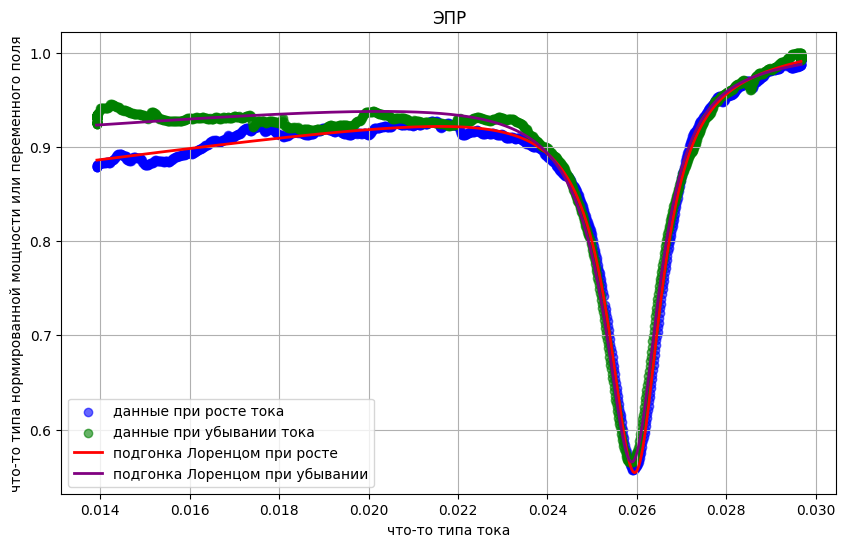

Интерполяционные коэффициенты для возрастания тока:
u0 = 0.7989, x0 = 2.6008e-02, k = 8.2462, a = 0.4262, b = 89.1212, d = 7.0821e-04
Интерполяционные коэффициенты для убывания тока:
u0 = 0.8751, x0 = 2.5954e-02, k = 4.4056, a = 0.4168, b = 97.9485, d = -7.4283e-04


In [5]:
# Функция Лоренца
def lorentzian(x, u0, x0, k, a, b, d): # u0 убрал из формулы, тк в итоге работаем с нормированными величинами, но оставим её здесь на всякий случай
    return u0*(1 + k * x) * (
        1 - a / (1 + ((x - x0) / d) ** 2) + b * (x - x0) / (1 + ((x - x0) / d) ** 2)
    )

# Считывание данных из файла
filename = '/home/golenn/EPR/data/23 14GHz 270degr.dat'
data = pd.read_csv(filename, skiprows=3, sep='\t')
data.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
x_data = data["X_channel"].values
y_data = data["Y_channel"].values

# Нормировка по Y для возрастания и убывания тока
x_idx_max = np.argmax(x_data)

y_max = max(y_data)
for i in range(len(y_data)):
    y_data[i] = y_data[i] / y_max 

y1_data = y_data[:x_idx_max]
x1_data = x_data[:x_idx_max]
y2_data = y_data[x_idx_max:]
x2_data = x_data[x_idx_max:]

# Начальные приближения параметров для случаев возрастания и убывания тока
u0_guess_1, u0_guess_2 = 1, 0.98
x0_guess_1 = x1_data[np.argmax(y1_data)]
x0_guess_2 = x2_data[np.argmax(y2_data)]
initial_guess_1 = [u0_guess_1, x0_guess_1, 1, 0.1, 0.1, 0.1]
initial_guess_2 = [u0_guess_2, x0_guess_2, -2, 0.1, 0.1, 0.1]

# Подбор параметров для случаев возрастания и убывания тока
params1, params_cov1 = curve_fit(lorentzian, x1_data, y1_data, p0=initial_guess_1)
params2, params_cov2 = curve_fit(lorentzian, x2_data, y2_data, p0=initial_guess_2)

# Генерация кривых для графика
x_fit1 = np.linspace(min(x1_data), max(x1_data), 500)
y_fit1 = lorentzian(x_fit1, *params1)
x_fit2 = np.linspace(min(x2_data), max(x2_data), 500)
y_fit2 = lorentzian(x_fit2, *params2)

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(x1_data, y1_data, color='blue', label='данные при росте тока', alpha=0.6)
plt.scatter(x2_data, y2_data, color='green', label='данные при убывании тока', alpha=0.6)
plt.plot(x_fit1, y_fit1, color='red', label='подгонка Лоренцом при росте', linewidth=2)
plt.plot(x_fit2, y_fit2, color='purple', label='подгонка Лоренцом при убывании', linewidth=2)
plt.title('ЭПР')
plt.ylabel('что-то типа нормированной мощности или переменного поля')
plt.xlabel('что-то типа тока')
plt.legend()
plt.grid()
plt.savefig(fname='EPR 14 GHz')
plt.show()
# Вывод параметров
print("Интерполяционные коэффициенты для возрастания тока:")
print(f"u0 = {params1[0]:.4f}, x0 = {params1[1]:.4e}, k = {params1[2]:.4f}, "
      f"a = {params1[3]:.4f}, b = {params1[4]:.4f}, d = {params1[5]:.4e}")

print("Интерполяционные коэффициенты для убывания тока:")
print(f"u0 = {params2[0]:.4f}, x0 = {params2[1]:.4e}, k = {params2[2]:.4f}, "
      f"a = {params2[3]:.4f}, b = {params2[4]:.4f}, d = {params2[5]:.4e}")


## Сбор данных по всем опытам на 11.43 ГГц
